# Boltzman wealth model

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation

## Ćwiczenie 1.1
Spróbuj zmodyfikować kod tak, aby w każdym kroku symulacji agenci wypisywali swoje id.

Do zaimplementowania metoda step w agencie.

In [5]:
class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
        
    def step(self):
        # The agent's step will go here.
        print(self.unique_id)

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

In [7]:
empty_model = MoneyModel(10)
empty_model.step()

0
1
3
9
8
4
5
2
7
6


## Ćwiczenie 1.2
Zaimplementuj metodę step w agencie tak, aby w każdym kroku przekazywał jednostkę pieniędzy (jeżeli posiada chociaż 1) innemu losowemu agentowi.

Przydatne rzeczy: <br/>
self.random.choice(agent_list) - funkcja zwraca losowego agenta z listy <br/>
self.model.schedule.agents - lista wszystkich agentów w modelu

In [10]:
class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
        
    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

(array([ 3.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  3.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

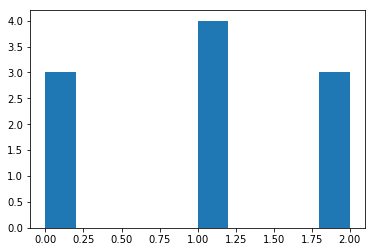

In [15]:
model = MoneyModel(10)
model.step()

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

(array([ 395.,  372.,  181.,    0.,   22.,    0.,    0.,    5.,    0.,   25.]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ]),
 <a list of 10 Patch objects>)

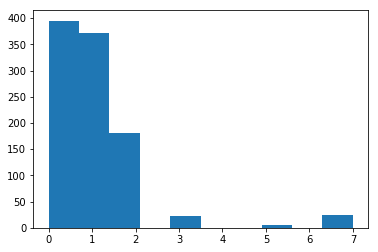

In [28]:
all_wealth = []
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth)

## Ćwiczenie 1.3
Teraz dodamy przestrzeń do symulacji.

Agenci znajdują się na siatce, mogą przemieścić się na dowolne pole z sąsiedztwa Moore'a i przekazać pieniądze tylko agentom znajdującym się na tym samym polu.

Sprawdź jak wygląda rozmieszczenie agentów na siatce.

In [31]:
from mesa.space import MultiGrid

In [32]:
class MoneyModel(Model):
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [33]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

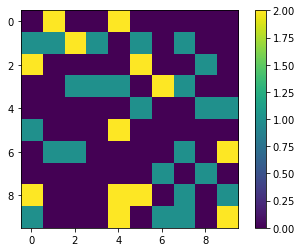

In [34]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

## Ćwiczenie 1.4
Teraz dodajemy zbieranie danych w czasie symulacji.

In [35]:
from mesa.datacollection import DataCollector

In [36]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},  # `compute_gini` defined above
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [37]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

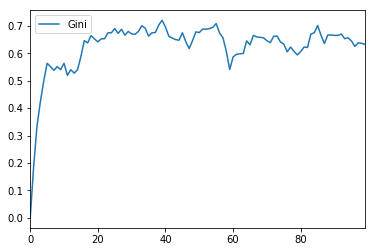

In [38]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

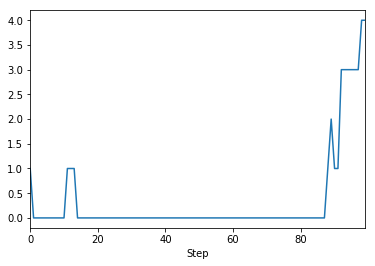

In [41]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
one_agent_wealth = agent_wealth.xs(0, level="AgentID")
one_agent_wealth.Wealth.plot()

Spróbuj narysować wykres największego bogactwa od kroku symulacji.

Przydatne rzeczy: <br/>
<b>wealth_per_agent = agent_wealth.xs(step, level="Step")</b>  zwróci nam dataframe zawierający wartości bogactwa dla każdego agenta w kroku step.<br/>
<b>wealth_per_agent.xs(agent_id).Wealth</b>  zwróci nam wartość bogactwa agenta o konkretnym id

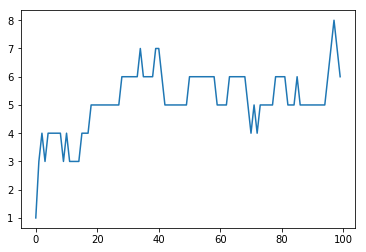

In [58]:
max_wealths = list()
for step in range(100):
    wealth_per_agent = agent_wealth.xs(step, level="Step")
    max_wealths.append(max([wealth_per_agent.xs(agent_id).Wealth for agent_id in range(50)]))
plt.plot(range(100), max_wealths)

## Ćwiczenie 1.5
Wklej klasy MoneyModel, MoneyAgent i funkcję compute_gini do pliku MoneyModel_viz.py, dodaj do MoneyModel atrybut running=True.
Uruchom wizualizację.<br/>
Spróbuj zmienić sposób w jaki wyświetlani są agenci bez pieniędzy.<br/>
W tym celu zmodyfikuj funkcję agent_portrayal. <br/>

Przydatne rzeczy: <br/>
Funkcja agent_portrayal zwraca słownik z atrybutami Shape, Filled, Layer, Color, r<br/>
Możesz zmodyfikować słownik na podstawie atrybutu agent.wealth

# Zadanie domowe
Tworzymy sieć jak na obrazku:
![title](network.png)
Załóżmy, że sieć reprezentuje routery i chcemy przesłać pakiet od pierwszego od lewej do ostatniego.<br/>
Routery oprócz pierwszego i ostatniego mogą losowo się psuć przez co są nieaktywne zanim zostaną naprawione.<br/>
Router wysyła wiadomość dalej do pierwszego od góry i czeka na potwierdzenie. Jeżeli nie dostanie potwierdzenia wysyła do następnego pod nim. <br/>
Przy jakim współczynniku psucia się routerów (prawdopodobieństwo, że router się zepsuje w danym kroku) sieć będzie dostępna przez 90% czasu jeżeli naprawa routera wymaga 20 kroków czasowych?